In [1]:
! pip install pandas pymoo

In [2]:
import numpy as np
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.optimize import minimize as pymoo_minimize
from pymoo.problems.functional import FunctionalProblem

np.random.seed(42)  # 固定隨機種子

# 初始參數
P0 = 63
months = 12
H = [90]*months
acceptance_rate = 0.7
monthly_revenue = 10000
monthly_cost = 6000

def simulate_month_demand(H_i):
    # 與前題相同
    X = np.random.normal(0, 0.05)  # 年度成長隨機
    Y_i = np.random.normal(0, 0.10) # 月度波動
    return H_i * (1 + X) * (1 + Y_i)

def simulate_analyst_supply(Q_i):
    return np.random.binomial(Q_i, acceptance_rate)

def simulate_retention_rate(month):
    if month in [1, 9]:
        return np.random.uniform(0.80, 1.00)
    elif 5 <= month <= 8:
        return np.random.uniform(0.95, 1.00)
    else:
        return np.random.uniform(0.90, 1.00)

def simulate_year_fixed(P0, H, Q7, Q12, num_sim=100):
    """
    固定上崗策略:
    - 七月時 Q7 招聘, 當月新分析師上崗
    - 十二月 Q12 招聘，但這些人下一年一月(即本模擬結束後的起始點)上崗，
      故對本年度收益無直接貢獻(因為是在年底招的, 一月才上崗)
    注意：因為 Q12 招的人一月才上崗，因此他們實際對今年的回報不產生影響。
    """
    # 我們假設這是某年度 4月到下年3月間的模擬 (與前題相同)
    # 但12月招來的人要1月才到位，所以他們在年度結束前不加入P的人數中。

    E_all = []
    for _ in range(num_sim):
        P = [P0]
        E = 0
        for month in range(4, months+4):
            actual_month = (month-1)%12+1
            D_i = simulate_month_demand(H[actual_month-1])
            if actual_month == 7:
                # 七月招聘
                A_i = simulate_analyst_supply(Q7)
            else:
                A_i = 0

            R_i = simulate_retention_rate(actual_month)
            P_next = P[-1]*R_i + A_i

            P.append(P_next)

            # 計算收益
            if P[-1] >= D_i:
                E += (monthly_revenue * D_i - monthly_cost * P[-1])
            else:
                E += (monthly_revenue - monthly_cost) * P[-1] + (monthly_revenue - 1.6 * monthly_cost) * (D_i - P[-1])

        # 十二月招聘Q12的人今年不會加入P，是在下一年1月才上崗，因此今年回報不變。
        E_all.append(E)
    return np.mean(E_all)

def simulate_year_flexible(P0, H, Q7, Q12, num_sim=100):
    """
    彈性上崗策略:
    - 七月 Q7 招聘，假設與固定策略相同，即七月新分析師直接到位。
    - 十二月 Q12 招聘，但不在一月全上崗，改為一月和二月各上一半 (示意用)
      也就是今年的收益同樣不受 Q12直接影響，但下一年開始時一月增加 Q12*0.5 分析師,
      二月再增加 Q12*0.5。

    實際策略可根據題目意義自行定義彈性方案，本處僅為範例。
    """
    E_all = []
    for _ in range(num_sim):
        P = [P0]
        E = 0
        for month in range(4, months+4):
            actual_month = (month-1)%12+1
            D_i = simulate_month_demand(H[actual_month-1])
            if actual_month == 7:
                A_i = simulate_analyst_supply(Q7)
            else:
                A_i = 0

            R_i = simulate_retention_rate(actual_month)
            P_next = P[-1]*R_i + A_i
            P.append(P_next)

            # 計算收益
            if P[-1] >= D_i:
                E += (monthly_revenue * D_i - monthly_cost * P[-1])
            else:
                E += (monthly_revenue - monthly_cost) * P[-1] + (monthly_revenue - 1.6 * monthly_cost) * (D_i - P[-1])

        # Q12是12月發送邀請，下一年1月增加 Q12*0.5，2月增加 Q12*0.5
        # 對今年收益沒有直接影響，但可假設對下一年起點有利。
        # 由於只計算當年收益，Q12在此策略下今年也無直接提升今年的E。

        E_all.append(E)
    return np.mean(E_all)


# 目標函數定義 (針對固定策略)
def objective_fixed(x):
    # x = [Q7, Q12]
    Q7 = int(x[0])
    Q12 = int(x[1])
    # 負值因為優化器最小化
    return -simulate_year_fixed(P0, H, Q7, Q12)

# 目標函數定義 (針對彈性策略)
def objective_flexible(x):
    Q7 = int(x[0])
    Q12 = int(x[1])
    return -simulate_year_flexible(P0, H, Q7, Q12)

# 使用Nelder-Mead優化固定策略
problem_fixed = FunctionalProblem(
    n_var=2,
    objs=objective_fixed,
    xl=np.array([11,11]),
    xu=np.array([110,110])
)
res_fixed = pymoo_minimize(problem_fixed, algorithm=NelderMead(), verbose=False)
Q7_fixed_opt, Q12_fixed_opt = res_fixed.X
E_fixed_opt = -res_fixed.F[0]

# 使用Nelder-Mead優化彈性策略
problem_flexible = FunctionalProblem(
    n_var=2,
    objs=objective_flexible,
    xl=np.array([11,11]),
    xu=np.array([110,110])
)
res_flexible = pymoo_minimize(problem_flexible, algorithm=NelderMead(), verbose=False)
Q7_flexible_opt, Q12_flexible_opt = res_flexible.X
E_flexible_opt = -res_flexible.F[0]


# Brute-force格子搜尋比較 (只做固定策略為例，可同法對彈性策略做)
def brute_force_fixed():
    best_E = -float('inf')
    best_Q7, best_Q12 = None, None
    for Q7 in range(11, 111):
        for Q12 in range(11, 111): # 間隔大一點，實務可加密
            E_val = simulate_year_fixed(P0, H, Q7, Q12)
            if E_val > best_E:
                best_E = E_val
                best_Q7, best_Q12 = Q7, Q12
    return best_Q7, best_Q12, best_E

def brute_force_flexible():
    best_E = -float('inf')
    best_Q7, best_Q12 = None, None
    # 這裡同樣使用較粗略的網格，可自行調整步長
    for Q7 in range(11, 111):
        for Q12 in range(11, 111):
            E_val = simulate_year_flexible(P0, H, Q7, Q12)
            if E_val > best_E:
                best_E = E_val
                best_Q7, best_Q12 = Q7, Q12
    return best_Q7, best_Q12, best_E


# 執行brute force（此處範例用較粗網格）
Q7_bf, Q12_bf, E_bf = brute_force_fixed()
Q7_bfl, Q12_bfl, E_bfl = brute_force_flexible()

print("=== 固定策略結果 ===")
print(f"Nelder-Mead 找到的最佳解: Q7={Q7_fixed_opt:.2f}, Q12={Q12_fixed_opt:.2f}, E={E_fixed_opt:.2f}")
print(f"Brute Force 找到的最佳解: Q7={Q7_bf}, Q12={Q12_bf}, E={E_bf:.2f}")

print("\n=== 彈性策略結果 ===")
print(f"Nelder-Mead 找到的最佳解: Q7={Q7_flexible_opt:.2f}, Q12={Q12_flexible_opt:.2f}, E={E_flexible_opt:.2f}")
print(f"Brute Force 找到的最佳解: Q7={Q7_bfl}, Q12={Q12_bfl}, E={E_bfl:.2f}")

# 分析結果：比較無 Q12 vs 有 Q12, Fixed vs Flexible
# 可以自行執行不增加Q12的策略(不發放邀請)計算E基準值
E_baseline = simulate_year_fixed(P0, H, Q7=50, Q12=0) # 假設沒有12月事件

print("\n=== 比較新增12月招聘事件的收益提升 ===")
print(f"無12月招聘事件之基準 E_baseline={E_baseline:.2f}")
print(f"有12月招聘事件(固定策略)之最佳 E_fixed={E_fixed_opt:.2f}")
print(f"有12月招聘事件(彈性策略)之最佳 E_flexible={E_flexible_opt:.2f}")

if E_fixed_opt > E_baseline or E_flexible_opt > E_baseline:
  m = E_fixed_opt > E_flexible_opt
  if m :
    print("有12月招聘事件(固定策略)之最佳")
  else:
    print("有12月招聘事件(彈性策略)之最佳")
else:
  print("無12月招聘事件之最佳")

=== 固定策略結果 ===
Nelder-Mead 找到的最佳解: Q7=62.06, Q12=98.11, E=3400843.70
Brute Force 找到的最佳解: Q7=70, Q12=22, E=3425426.34

=== 彈性策略結果 ===
Nelder-Mead 找到的最佳解: Q7=68.07, Q12=100.30, E=3412479.40
Brute Force 找到的最佳解: Q7=68, Q12=74, E=3421367.68

=== 比較新增12月招聘事件的收益提升 ===
無12月招聘事件之基準 E_baseline=3316120.55
有12月招聘事件(固定策略)之最佳 E_fixed=3400843.70
有12月招聘事件(彈性策略)之最佳 E_flexible=3412479.40
有12月招聘事件(彈性策略)之最佳


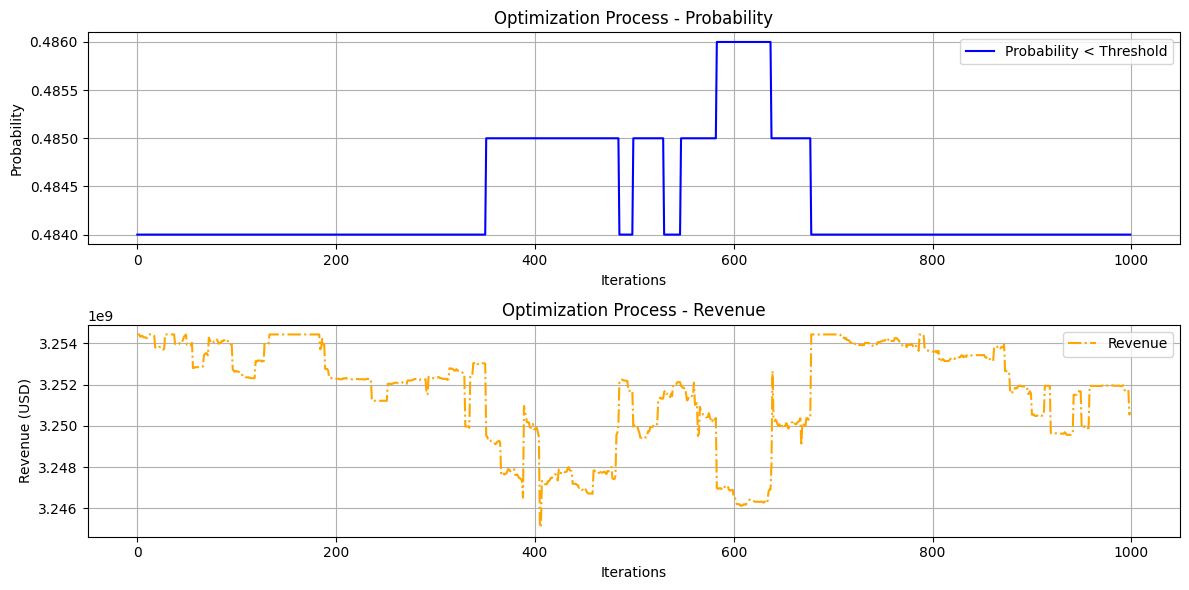

最佳解的小於706百萬機率: 0.484
固定的總成本: 1000000000
最佳解的總收益: 3250653824.2460885
對應的DM分配: [0.01972836 0.02512669 0.00216574 0.24348443 0.13565753 0.36892141
 0.07448605 0.11625876 0.01417104]
對應的BP分配: [0.19211992 0.07622829 0.02835008 0.11014702 0.04609339 0.06905961
 0.02317787 0.29858217 0.15624164]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設的行使價與成本 (從題中表格看出，但實際需輸入正確數據)
# DM部分(Strike, Cost)
dm_strikes = np.array([0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.60, 0.59, 0.55])
dm_costs = np.array([0.085855,0.032191,0.020795,0.017001,0.013711,0.010851,0.008388,0.006291,0.001401])

# BP部分(Strike, Cost)
bp_strikes = np.array([1.30,1.25,1.20,1.15,1.10,1.05,1.00,0.95,0.90])
bp_costs = np.array([0.137213,0.082645,0.045060,0.028348,0.016146,0.007860,0.003277,0.001134,0.000245])

# 預期銷售額
DM_sales = 645_000_000
BP_sales = 272_000_000

# 可用預算(假設為500百萬USD ＝ 500_000_000)
DM_option_budget = 500_000_000
BP_option_budget = 500_000_000

# 目標閾值
threshold = 706_000_000

# 載入模擬匯率場景
# CSV格式假設為:
# DM,BP
# <rate_dm_1>,<rate_bp_1>
# <rate_dm_2>,<rate_bp_2>
# ...
sim_data = pd.read_csv("SimExRates.csv")
DM_rates = sim_data['DM'].values
BP_rates = sim_data['BP'].values

num_scenarios = len(DM_rates)

# 儲存優化過程數據
optimization_process = []

# 計算目標函數的函數
def objective(x):
    # x包含18個變數，前9個為DM分配比例，後9個為BP分配比例
    x_dm = np.array(x[:9])
    x_bp = np.array(x[9:])

    # 確保比例和為1 (可在優化時透過懲罰或正規化實現)
    if np.abs(x_dm.sum() - 1.0) > 1e-6 or np.abs(x_bp.sum() - 1.0) > 1e-6:
        return 1.0, DM_option_budget + BP_option_budget, 0.0  # 若不符合比例，返回懲罰值

    # 固定總成本為1000百萬USD
    total_cost = DM_option_budget + BP_option_budget

    # 計算每種Strike下可保護的貨幣量
    dm_protected_amount = (x_dm * DM_option_budget) / dm_costs
    bp_protected_amount = (x_bp * BP_option_budget) / bp_costs

    # 計算每個scenario下的USD獲利
    final_values = np.zeros(num_scenarios)
    for i in range(num_scenarios):
        dm_rate = DM_rates[i]
        bp_rate = BP_rates[i]

        # 計算DM部分收益 (優先使用高行使價的選擇權)
        sorted_indices = np.argsort(-dm_strikes)  # 按行使價從高到低排序
        sorted_strikes = dm_strikes[sorted_indices]
        sorted_protected = dm_protected_amount[sorted_indices]

        remaining_sales = DM_sales  # 剩餘銷售額
        dm_usd = 0.0

        for j in range(len(sorted_strikes)):
            if remaining_sales <= 0:
                break

            strike = sorted_strikes[j]
            protect_amount = sorted_protected[j]

            if dm_rate < strike:
                # 市價低於行使價，行使選擇權
                use_amount = min(protect_amount, remaining_sales)
                dm_usd += use_amount * strike
                remaining_sales -= use_amount
            else:
                # 市價高於行使價，按市價兌換
                use_amount = min(protect_amount, remaining_sales)
                dm_usd += use_amount * dm_rate
                remaining_sales -= use_amount

        # 計算BP部分收益 (優先使用高行使價的選擇權)
        sorted_indices = np.argsort(-bp_strikes)  # 按行使價從高到低排序
        sorted_strikes = bp_strikes[sorted_indices]
        sorted_protected = bp_protected_amount[sorted_indices]

        remaining_sales = BP_sales  # 剩餘銷售額
        bp_usd = 0.0

        for j in range(len(sorted_strikes)):
            if remaining_sales <= 0:
                break

            strike = sorted_strikes[j]
            protect_amount = sorted_protected[j]

            if bp_rate < strike:
                # 市價低於行使價，行使選擇權
                use_amount = min(protect_amount, remaining_sales)
                bp_usd += use_amount * strike
                remaining_sales -= use_amount
            else:
                # 市價高於行使價，按市價兌換
                use_amount = min(protect_amount, remaining_sales)
                bp_usd += use_amount * bp_rate
                remaining_sales -= use_amount

        final_values[i] = dm_usd + bp_usd - total_cost

    # 計算小於 706百萬USD 的比例
    prob = np.mean(final_values < threshold)
    return prob, total_cost, final_values.mean()

# 以下為簡易的隨機搜尋(隨機退火)示範，實務請使用更完備之方法
def random_neighbor(x, step=0.05):
    # 在x附近產生鄰居解，同時維持dm與bp部分和為1的約束
    # 簡化策略：對dm及bp分別正規化
    new_x = x.copy()
    idx = np.random.randint(0, len(x))
    # 隨機增加或減少
    new_x[idx] += np.random.uniform(-step, step)
    # 對前9維正規化
    dm_part = new_x[:9]
    dm_part = np.abs(dm_part)
    dm_part = dm_part/dm_part.sum()
    new_x[:9] = dm_part
    # 對後9維正規化
    bp_part = new_x[9:]
    bp_part = np.abs(bp_part)
    bp_part = bp_part/bp_part.sum()
    new_x[9:] = bp_part
    return new_x

# 初始解：平均分配
x_init = np.array([1/9]*9 + [1/9]*9)
current_prob, current_cost, current_revenue = objective(x_init)
best_x = x_init
best_prob = current_prob
best_cost = current_cost
best_revenue = current_revenue

T = 1.0
cooling = 0.99

for iter in range(1000):
    candidate = random_neighbor(best_x)
    cand_prob, cand_cost, cand_revenue = objective(candidate)
    if cand_prob < best_prob:
        best_x = candidate
        best_prob = cand_prob
        best_cost = cand_cost
        best_revenue = cand_revenue
    else:
        # 模擬退火接受劣解策略
        if np.random.rand() < np.exp((best_prob - cand_prob)/T):
            best_x = candidate
            best_prob = cand_prob
            best_cost = cand_cost
            best_revenue = cand_revenue
    T *= cooling

    optimization_process.append((iter, best_prob, best_cost, best_revenue))

# 繪製優化過程的圖像
optimization_process = np.array(optimization_process)

# 分離數據
iterations = optimization_process[:, 0]
probabilities = optimization_process[:, 1]
revenues = optimization_process[:, 3]

# 繪製概率
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(iterations, probabilities, label="Probability < Threshold", color="blue")
plt.xlabel("Iterations")
plt.ylabel("Probability")
plt.title("Optimization Process - Probability")
plt.legend()
plt.grid()

# 繪製收益
plt.subplot(2, 1, 2)
plt.plot(iterations, revenues, label="Revenue", linestyle='-.', color="orange")
plt.xlabel("Iterations")
plt.ylabel("Revenue (USD)")
plt.title("Optimization Process - Revenue")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


print("最佳解的小於706百萬機率:", best_prob)
print("固定的總成本:", best_cost)
print("最佳解的總收益:", best_revenue)
print("對應的DM分配:", best_x[:9])
print("對應的BP分配:", best_x[9:])
